In [1]:
import os
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

Using TensorFlow backend.


In [2]:
# Generating Labels out of the Training data

imdb_dir = 'C:\\Users\\Ceeva\\Desktop\\Github\\TextAndSequence-DeepLearning\\aclImdb'
train_dir = os.path.join(imdb_dir, 'train')
labels = []
texts = []
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding= 'utf8')
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [3]:
# Tokenizing the data

maxlen = 100 # Cuts off reviews after 100 words
training_samples = 200 # Train on 200 samples
validation_samples = 10000 # Validate on 10000 samples
max_words = 10000 # Consider only top 10000 words in the dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


In [4]:
# Parsing the GloVe word-embeddings file

glove_dir = 'C:\\Users\\Ceeva\\Desktop\\Github\\TextAndSequence-DeepLearning'
embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding='utf8')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print('Found {} word vectors.'.format(len(embeddings_index)))

# Preparing the GloVe word-embeddings matrix

embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

Found 400000 word vectors.


In [5]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False # Freezing to use the Pre-Trained Values

model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 320,065
Non-trainable params: 1,000,000
_________________________________________________________________


In [6]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(x_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_data=(x_val, y_val))

model.save_weights('pre_trained_glove_model.h5')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 200 samples, validate on 10000 samples
Epoch 1/20
200/200 [==============================] - 1s 3ms/step - loss: 1.6829 - acc: 0.4850 - val_loss: 0.7174 - val_acc: 0.5039
Epoch 2/20
200/200 [==============================] - 0s 2ms/step - loss: 0.5404 - acc: 0.7300 - val_loss: 0.7543 - val_acc: 0.5081
Epoch 3/20
200/200 [==============================] - 0s 2ms/step - loss: 0.3958 - acc: 0.8150 - val_loss: 0.7383 - val_acc: 0.5283
Epoch 4/20
200/200 [==============================] - 0s 2ms/step - loss: 0.2573 - acc: 0.9600 - val_loss: 0.9136 - val_acc: 0.5140
Epoch 5/20
200/200 [==============================] - 0s 2ms/step - loss: 0.3028 - acc: 0.9100 - val_loss: 0.9001 - val_acc: 0.5070
Epoch 6/20
200/200 [==============================] - 0s 2ms/step - loss: 0.1410 - acc: 0.9950 - val_loss: 0.8549 - val_acc: 0.5305
Epoch 7/20
200/200 [==============================] - 0s 2ms/step

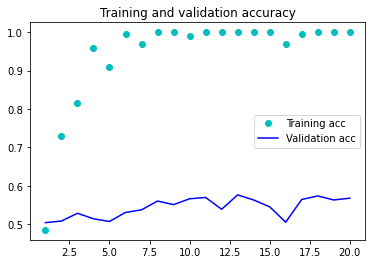

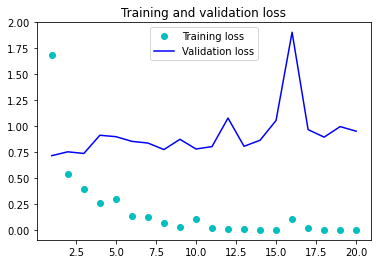

In [7]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'co', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'co', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [8]:
# Overfitting level 1000! Damn
# So we now try without the pretrained Word Embeddings

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(x_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_data=(x_val, y_val))

Train on 200 samples, validate on 10000 samples
Epoch 1/20
200/200 [==============================] - 1s 3ms/step - loss: 0.6926 - acc: 0.4950 - val_loss: 0.6936 - val_acc: 0.5074
Epoch 2/20
200/200 [==============================] - 1s 3ms/step - loss: 0.4980 - acc: 0.9850 - val_loss: 0.6971 - val_acc: 0.5101
Epoch 3/20
200/200 [==============================] - 1s 3ms/step - loss: 0.2779 - acc: 1.0000 - val_loss: 0.7050 - val_acc: 0.5195
Epoch 4/20
200/200 [==============================] - 1s 3ms/step - loss: 0.1310 - acc: 0.9900 - val_loss: 0.7206 - val_acc: 0.5138
Epoch 5/20
200/200 [==============================] - 1s 3ms/step - loss: 0.0616 - acc: 1.0000 - val_loss: 0.7144 - val_acc: 0.5191
Epoch 6/20
200/200 [==============================] - 1s 3ms/step - loss: 0.0314 - acc: 1.0000 - val_loss: 0.7265 - val_acc: 0.5194
Epoch 7/20
200/200 [==============================] - 1s 3ms/step - loss: 0.0176 - acc: 1.0000 - val_loss: 0.7196 - val_acc: 0.5245
Epoch 8/20
200/200 [========

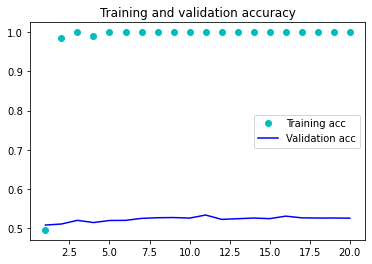

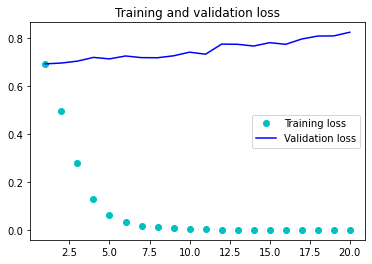

In [10]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'co', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'co', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [11]:
# Generating the Labels for test dataset
test_dir = os.path.join(imdb_dir, 'test')
labels = []
texts = []
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding='utf8')
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

In [12]:
model.load_weights('pre_trained_glove_model.h5')
print(model.evaluate(x_test, y_test))

25000/25000 [==============================] - 1s 45us/step
[0.951253497467041, 0.5694400072097778]
